# Generating the Input Joint Distribtution 

The first step to apply an information bottleneck algorithm is to define a proper input distribution $p(x,y)$ which describes the relation between the relevant variable $X$ and the observed random variable $Y$ 

First, we assume an AWGN channel with BPSK transmission.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import pyldpc as ldpc
import os
from tqdm.notebook import tqdm
from scipy.stats import norm
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
sigma_n2 = 0.3 # Noise variance
amplitudes = np.array([-1,+1]) # BPSK amplitudes are +1 and -1

p_x = np.array([0.5,0.5]) # uniformly distributed transmit symbols

card_Y = 2000 # choose a fine discretization of the cont. variable Y
card_T = 16   # cardinality of the compression variable
y = np.linspace(norm.ppf(1e-12, loc=amplitudes.min(), scale=np.sqrt(sigma_n2)),
                norm.ppf(1-1e-12, loc=amplitudes.max(), scale=np.sqrt(sigma_n2)), card_Y) # define the eventspace
delta_y = np.abs(y[1] - y[0])

p_y_given_x = np.zeros((y.shape[0],2))
for x_idx, x in enumerate(amplitudes):
    p_y_given_x[:,x_idx] = norm.pdf(y, loc=x, scale=np.sqrt(sigma_n2))*delta_y
    
p_y_and_x = p_y_given_x * p_x
p_y_and_x /= p_y_and_x.sum()

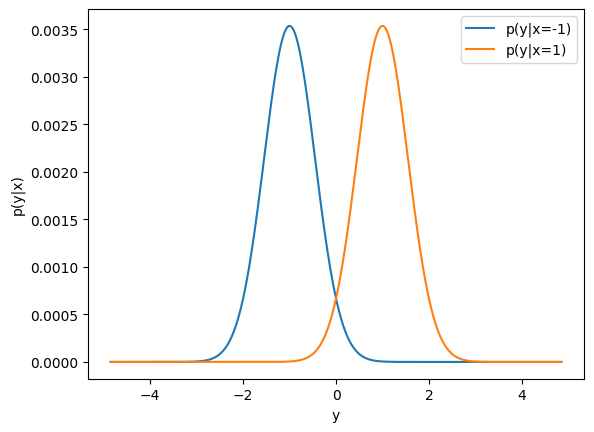

In [3]:
plt.figure()
for x_idx, x in enumerate(amplitudes):
    plt.plot(y,p_y_given_x[:,x_idx],label="p(y|x="+str(x)+")")
plt.ylabel("p(y|x)")
plt.xlabel("y")
plt.legend()
plt.show()

## Import Information theory tools

In [4]:
from IB_Decoder_Classes import mutual_information as mutual_inf

## Running Information Bottleneck Algorithms

In this section, we will use three exemplary information bottleneck algorithm to show the syntax of the respective algorithms and how to access the lookup table $p(t|y)$ and the cluster meaning $p(x|t)$.

In [5]:
from IB_Decoder_Classes import GenericIB

### Sequential Symmetric Information Bottleneck Algorithm [LB18]

In [6]:
from IB_Decoder_Classes import symmetric_sIB

In [7]:
IB_algo = symmetric_sIB(p_x_y_=p_y_and_x,
                        card_T_=card_T,
                        nror_=10)
IB_algo.run_IB_algo()

Run: [######################################################################] 100.0% 10 / 10    



In [10]:
IB_algo.display_MIs()

----- Mutual Information Comp --- 
-----  symmetric sIB  ------ 
MI_XT_s=  0.8713385259477824
MI_XY_s=  0.8724135198414117
ratio=  0.9987677931747038


In [11]:
# LUT p(t|x)
p_t_given_y, p_x_given_t, p_t  = IB_algo.get_results()
LUT = np.argmax(IB_algo.p_t_given_y,axis=1)

In [15]:
LUT

array([ 0,  0,  0, ..., 15, 15, 15], dtype=int64)

Text(0, 0.5, 'L(x|t)')

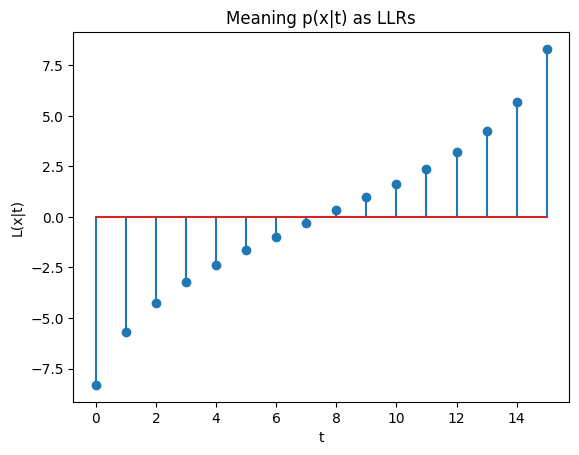

In [12]:
plt.stem(np.arange(card_T),np.log(p_x_given_t[:,1]/p_x_given_t[:,0]))
plt.title("Meaning p(x|t) as LLRs")
plt.xlabel("t")
plt.ylabel("L(x|t)")

### Neural Decoder

In [11]:
class AWGN_BPSK_Dataset(Dataset):
    def __init__(self, 
                 sigma_n2=0.3, 
                 card_Y = 2000,
                 card_T = 16,
                 message_num = 1000):
        self.sigma_n2 = sigma_n2
        self.card_Y = card_Y
        self.card_T = card_T
        self.amplitudes = torch.tensor([-1,+1]) # BPSK amplitudes are +1 and -1
        self.p_x = torch.tensor([0.5,0.5]) # uniformly distributed transmit symbols

        self.y = torch.linspace(norm.ppf(1e-12, loc=self.amplitudes.min().detach().numpy(), scale=np.sqrt(self.sigma_n2)),
                norm.ppf(1-1e-12, loc=self.amplitudes.max().detach().numpy(), scale=np.sqrt(self.sigma_n2)), \
                                self.card_Y) # define the eventspace
        
        self.delta_y = torch.tensor(abs(y[1] - y[0]))

        self.p_y_given_x = torch.zeros((self.y.shape[0],2))
        for x_idx, x in enumerate(self.amplitudes):
            self.p_y_given_x[:,x_idx] = torch.tensor(norm.pdf(self.y, loc=x, scale=np.sqrt(self.sigma_n2)) * \
                                                     self.delta_y.detach().numpy())

        self.p_y_and_x = self.p_y_given_x * self.p_x
        self.p_y_and_x /= p_y_and_x.sum()
        self.message_num = message_num
        self.IB_algo = symmetric_sIB(p_x_y_= self.p_y_and_x.detach().numpy(),
                        card_T_= self.card_T,
                        nror_=10)
        self.get_LUT()

    def get_LUT(self):
        # we need to create lookup tables

        self.IB_algo.run_IB_algo()
        p_t_given_y, p_x_given_t, p_t  = self.IB_algo.get_results()
        self.LUT = torch.argmax(torch.tensor(self.IB_algo.p_t_given_y), axis=1)    
        
    def __len__(self):
        return (self.card_Y)
    
    def __getitem__(self, idx):
        random_idx = torch.randint(low = 0, high = self.card_Y, size = (self.message_num,))
        return self.y[random_idx], self.LUT[random_idx]

In [12]:
dataset = AWGN_BPSK_Dataset(card_Y = 2000, message_num=1)

batch_size = 32
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=len(dataset))


Run: [######################################################################] 100.0% 10 / 10    



In [13]:
def epoch_train(loader, clf, criterion, opt):
    # BEGIN Solution (do not delete this comment!)

    clf.to(device)
    clf.train(True)

    avg_loss = []
    avg_accuracy = 0
    correct = 0
    total = 0

    for inputs, labels in loader:

        inputs, labels = inputs.to(device), labels.squeeze().to(device)
        outputs = clf(inputs)
        loss = criterion(outputs, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        avg_loss.append(loss.item())

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    avg_acc = correct / total

    return np.mean(avg_loss), avg_acc
    # END Solution (do not delete this comment!)

def epoch_test(loader, clf, criterion):
    # BEGIN Solution (do not delete this comment!)

    clf.to(device)
    clf.eval()

    avg_loss = []
    avg_accuracy = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:  
            inputs, labels = inputs.to(device), labels.squeeze().to(device)
            outputs = clf(inputs)

            loss = criterion(outputs, labels)

            avg_loss.append(loss.item())

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_acc = correct / total

    return np.mean(avg_loss), avg_acc
    # END Solution (do not delete this comment!)

# The function which you are going to use for model training
def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    train_epoch_loss = np.zeros(n_epochs)
    test_epoch_loss = np.zeros(n_epochs)
    for epoch in tqdm(range(n_epochs)):
        train_epoch_loss[epoch], train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_epoch_loss[epoch], test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_epoch_loss[epoch]:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_epoch_loss[epoch]:.3f}; test acc: {test_acc:.2f}')
        
    return train_epoch_loss, test_epoch_loss

In [14]:
class MLP(nn.Module):
    def __init__(self, num_classes=16):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            # BEGIN Solution (do not delete this comment!)

            torch.nn.Flatten(),
            torch.nn.Linear(dataset.message_num, 16000),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(16000),
            
         
            torch.nn.Linear(16000, num_classes),
            #torch.nn.Linear(128, 10),
            #torch.nn.BatchNorm1d(10),
            #torch.nn.ReLU(),
            #torch.nn.Dropout(0.0),

            # END Solution (do not delete this comment!)
        )
        
    def forward(self, x):
        return self.layers(x)
    
clf_mlp = MLP(num_classes=16).cpu()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_mlp.parameters()]))

# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_dataloader))[0].cpu()
with torch.no_grad():
    clf_X = clf_mlp(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 16

Number of weights: 320016


In [15]:
#import gc
#gc.collect()
#torch.cuda.empty_cache()

In [16]:
num_epochs = 75

opt = torch.optim.Adam(clf_mlp.parameters(), lr=0.001, betas=(0.9, 0.95))
criterion = torch.nn.CrossEntropyLoss()

# END Solution (do not delete this comment!)

train_hist_loss, test_hist_loss = train(train_dataloader, test_dataloader, clf_mlp, criterion, opt, n_epochs=num_epochs)

  0%|          | 0/75 [00:00<?, ?it/s]

[Epoch 1] train loss: 2.109; train acc: 0.75; test loss: 1.177; test acc: 0.81
[Epoch 2] train loss: 1.190; train acc: 0.80; test loss: 1.047; test acc: 0.83
[Epoch 3] train loss: 1.382; train acc: 0.81; test loss: 1.458; test acc: 0.80
[Epoch 4] train loss: 1.023; train acc: 0.83; test loss: 0.768; test acc: 0.85
[Epoch 5] train loss: 0.804; train acc: 0.86; test loss: 1.083; test acc: 0.81
[Epoch 6] train loss: 1.018; train acc: 0.82; test loss: 0.607; test acc: 0.82
[Epoch 7] train loss: 0.799; train acc: 0.84; test loss: 0.637; test acc: 0.86
[Epoch 8] train loss: 0.799; train acc: 0.85; test loss: 0.753; test acc: 0.82
[Epoch 9] train loss: 0.795; train acc: 0.85; test loss: 0.524; test acc: 0.90
[Epoch 10] train loss: 0.895; train acc: 0.84; test loss: 0.519; test acc: 0.89
[Epoch 11] train loss: 0.895; train acc: 0.84; test loss: 0.426; test acc: 0.88
[Epoch 12] train loss: 0.647; train acc: 0.85; test loss: 0.582; test acc: 0.85
[Epoch 13] train loss: 0.668; train acc: 0.85; te

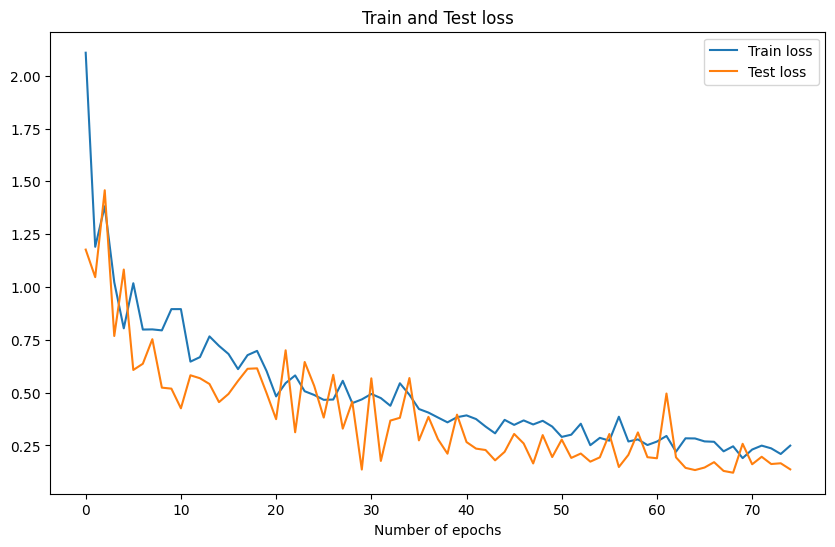

In [17]:
plt.figure(figsize=(10, 6))
plt.title("Train and Test loss")
plt.plot(range(num_epochs), train_hist_loss, label="Train loss")
plt.plot(range(num_epochs), test_hist_loss, label="Test loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.show()

### Agglomerative Information Bottleneck Algorithm [Slo02]

In [22]:
from IB_Decoder_Classes import aIB

In [23]:
IB_algo = aIB(p_x_y_=p_y_and_x,
              card_T_=card_T)
IB_algo.run_IB_algo()

In [24]:
IB_algo.display_MIs()

----- Mutual Information Comp --- 
-----  agglomerative IB  ------ 
MI_XT_s=  0.8711029730916213
MI_XY_s=  0.8724135198414117
ratio=  0.9984977917925566


In [25]:
# LUT p(t|y)
p_t_given_y, p_x_given_t, p_t  = IB_algo.get_results()
LUT = np.argmax(IB_algo.p_t_given_y,axis=1)

Text(0, 0.5, 'L(x|t)')

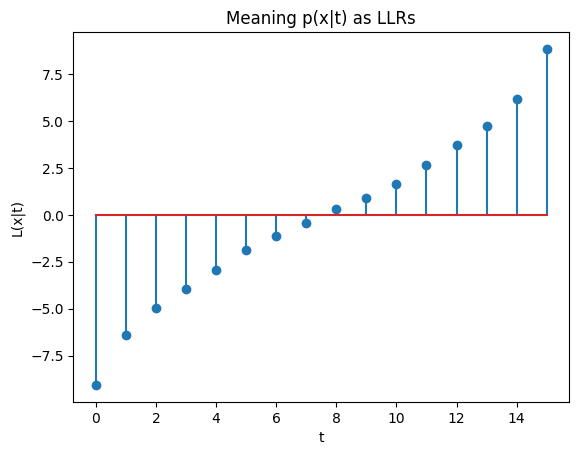

In [26]:
plt.stem(np.arange(card_T),np.log(p_x_given_t[:,1]/p_x_given_t[:,0]))
plt.title("Meaning p(x|t) as LLRs")
plt.xlabel("t")
plt.ylabel("L(x|t)")

### KL-Means Algorithm [K17] 

In [5]:
import progressbar
import pyopencl as cl
import pyopencl.array as cl_array
import pyopencl.tools as cl_tools
from mako.template import Template

from IB_Decoder_Classes import KLmeansIB

The KL-Means Algorithm uses PyOpenCl. First, you need to choose a context/plattform. This choice depends on your hardware the drivers etc.

In [6]:
import os
import os.path
os.environ['PYOPENCL_CTX'] = '0'

In [7]:
IB_algo = KLmeansIB(p_x_y_=p_y_and_x,
                  card_T_=card_T,
                  symmetric_init = True,
                  nror=100)
IB_algo.run_IB_algo()

###  OPENCL Device #####
[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x19bf05c10a0>]


 [Elapsed Time: 0:00:27] |###################################| (Time: 0:00:27) 


In [8]:
# LUT p(t|y)
p_t_given_y, p_x_given_t, p_t  = IB_algo.get_results()
LUT = np.argmax(IB_algo.p_t_given_y,axis=1)

Text(0, 0.5, 'L(x|t)')

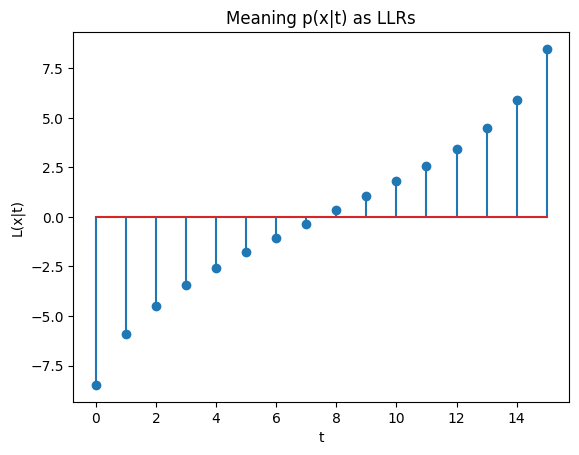

In [9]:
plt.stem(np.arange(card_T),np.log(p_x_given_t[:,1]/p_x_given_t[:,0]))
plt.title("Meaning p(x|t) as LLRs")
plt.xlabel("t")
plt.ylabel("L(x|t)")

## References
- [SLB18b] M. Stark, J. Lewandowsky, and G. Bauch, “Information-Bottleneck Decoding of High-Rate Irregular LDPC Codes for Optical Communication Using Message Alignment”, Applied Science. 2018; 8(10):1884
- [LB18] J. Lewandowsky and G. Bauch, “Information-Optimum LDPC Decoders Based on the Information Bottleneck Method,” IEEE Access, vol. 6, pp. 4054–4071, 2018.
- [Slo02] N. Slonim, “The Information Bottleneck Theory and Applications,” Hebrew University of Jerusalem, 2002.
- [K17] B. M. Kurkoski, “On the relationship between the KL means algorithm and the information bottleneck method,” in Proc. SCC 2017; 11th International ITG Conference on Systems, Communications and Coding, Feb 2017, pp. 1–6.